# KMeans Airbnb Project

## Part 1: Implement Clustering Algorithm
#### Class Definition: `KMeans`

#### Data Attributes:
- **data** (`numpy.ndarray`) - The dataset to be clustered.
- **num_clusters** (`int`) - The number of clusters to form.
- **centroids** (`numpy.ndarray`) - Current positions of the centroids.
- **cluster_assessment** (`numpy.ndarray`) - Matrix storing cluster assignments and distances.

#### Methods:
- **`__init__(self, data, k)`** - Initializes the KMeans instance with the data and number of clusters.
- **`get_distance(self, p1, p2)`** - Computes the Euclidean distance between two points.
- **`get_centroid(self)`** - Randomly generates initial centroids within the data's range.
- **`fit(self, max_iters=100, tol=1e-4)`** - Runs the K-means clustering algorithm, updating assignments and centroids until convergence.
- **`get_results(self)`** - Returns the final centroids and cluster assignment results for each data point.

In [1]:
# Part 1:

# Your code goes here

import random
import math

class KMeans:
    def __init__(self, data, k):
        """ Initialize the KMeans instance with data and number of clusters """
        self.data = data  # data is expected to be a list of lists
        self.num_clusters = k
        self.centroids = None
        self.cluster_assessment = None

    def get_distance(self, p1, p2):
        """ Calculate the Euclidean distance between two points """
        if len(p1) != len(p2):
            raise ValueError("Points must have the same dimensions.")
        return math.sqrt(sum((x - y) ** 2 for x, y in zip(p1, p2)))

    def get_centroid(self):
        """ Randomly generate k centroids within the data's range """
        min_vals = [min(col) for col in zip(*self.data)]
        max_vals = [max(col) for col in zip(*self.data)]
        centroids = set()
        while len(centroids) < self.num_clusters:
            candidate = tuple(random.uniform(min_val, max_val) for min_val, max_val in zip(min_vals, max_vals))
            centroids.add(candidate)
        return [list(c) for c in centroids]

    def fit(self, max_iters=100, tol=1e-4):
        """ K-means clustering algorithm """
        m = len(self.data)
        n = len(self.data[0]) if m > 0 else 0

        # Initialize centroids and cluster assignments
        self.centroids = self.get_centroid()
        self.cluster_assessment = [[-1, float('inf')] for _ in range(m)]

        for iteration in range(max_iters):
            cluster_change = False

            # Assign points to the closest centroid
            for i, point in enumerate(self.data):
                distances = [self.get_distance(point, centroid) for centroid in self.centroids]
                min_index = distances.index(min(distances))
                if self.cluster_assessment[i][0] != min_index:
                    cluster_change = True
                self.cluster_assessment[i] = [min_index, distances[min_index]]

            # Update centroids
            new_centroids = [[0] * n for _ in range(self.num_clusters)]
            counts = [0] * self.num_clusters
            for i, (cluster, _) in enumerate(self.cluster_assessment):
                counts[cluster] += 1
                for j in range(n):
                    new_centroids[cluster][j] += self.data[i][j]

            for j in range(self.num_clusters):
                if counts[j] > 0:
                    new_centroids[j] = [x / counts[j] for x in new_centroids[j]]

            # Check convergence
            if all(
                self.get_distance(new_centroids[j], self.centroids[j]) < tol
                for j in range(self.num_clusters)
            ):
                break

            self.centroids = new_centroids

    def get_results(self):
        """ Return the final centroids and cluster assignment results """
        return self.centroids, self.cluster_assessment

## Part 2: Algorithm Application
#### **Data Set Selection and Preparation** ####
The dataset selected for analysis is from Greater Manchester, England, United Kingdom, dated 26 June 2024. This dataset encompasses key information such as latitude, longitude, price, and room type.
#### **Application of Clustering Algorithm** ####
The k-means clustering algorithm, as implemented, will be utilized to analyze the dataset and identify clusters of Airbnb listings based on distinct feature combinations. Specifically, we will conduct clustering based on latitude and longitude (Model One), latitude, longitude, and price (Model Two), and latitude, longitude, and room type (Model Three).

In [2]:
# Part 2:

# Your code goes here

import pandas as pd
import random
random.seed(2024)

# load data 
url = "https://data.insideairbnb.com/united-kingdom/england/greater-manchester/2024-06-26/data/listings.csv.gz"
data_raw = pd.read_csv(url)

# filter data 
columns_to_select = [
    "id", 
    "latitude", 
    "longitude", 
    "room_type", 
    "price"
]
data_filter = data_raw[columns_to_select]

# wrangling
data_filter.loc[:, 'price'] = data_filter['price'].replace({r'\$': '', ',': ''}, regex=True).astype(float)
data_cleaned = data_filter.dropna().reset_index(drop=True)
room_type_map = {
    "Entire home/apt": 1,
    "Private room": 2,
    "Hotel room": 3,
    "Shared room": 4
}
data_cleaned['room_type_numeric'] = data_cleaned['room_type'].map(room_type_map)

# prepare for clustering
data_points_lat_lon = data_cleaned[["latitude", "longitude"]].values.tolist()
data_points_lat_lon_price = data_cleaned[["latitude", "longitude", "price"]].values.tolist()
data_points_lat_lon_room_type = data_cleaned[["latitude", "longitude", "room_type_numeric"]].values.tolist()
k = 5

# Model 1 - apply KMeans algorithm on latitude and longitude
kmeans_lat_lon = KMeans(data_points_lat_lon, k)
kmeans_lat_lon.fit()
centroids_lat_lon, cluster_assignments_lat_lon = kmeans_lat_lon.get_results()
data_cleaned['cluster_lat_lon'] = [int(assign[0]) for assign in cluster_assignments_lat_lon]

# Model 2 - apply KMeans algorithm on latitude, longitude and price
kmeans_lat_lon_price = KMeans(data_points_lat_lon_price, k)
kmeans_lat_lon_price.fit()
centroids_lat_lon_price, cluster_assignments_lat_lon_price = kmeans_lat_lon_price.get_results()
data_cleaned['cluster_lat_lon_price'] = [int(assign[0]) for assign in cluster_assignments_lat_lon_price]

# Model 3 - apply KMeans algorithm on latitude, longitude and room_type
kmeans_lat_lon_room_type = KMeans(data_points_lat_lon_room_type, k)
kmeans_lat_lon_room_type.fit()
centroids_lat_lon_room_type, cluster_assignments_lat_lon_room_type = kmeans_lat_lon_room_type.get_results()
data_cleaned['cluster_lat_lon_room_type'] = [int(assign[0]) for assign in cluster_assignments_lat_lon_room_type]

# summary for clusters based on latitude and longitude
cluster_summary_lat_lon = data_cleaned.groupby("cluster_lat_lon").agg(
    count=("id", "size"),
    avg_latitude=("latitude", "mean"),
    avg_longitude=("longitude", "mean"),
)
print("Cluster Summary for Latitude and Longitude(Model 1):")
print(cluster_summary_lat_lon)

# summary for clusters based on latitude, longitude, and price
cluster_summary_lat_lon_price = data_cleaned.groupby("cluster_lat_lon_price").agg(
    count=("id", "size"),
    avg_latitude=("latitude", "mean"),
    avg_longitude=("longitude", "mean"),
    avg_price=("price", "mean"),
)
print("\nCluster Summary for Latitude, Longitude, and Price(Model 2):")
print(cluster_summary_lat_lon_price)

# summary for clusters based on latitude, longitude, and room_type
cluster_summary_lat_lon_room_type = data_cleaned.groupby("cluster_lat_lon_room_type").agg(
    count=("id", "size"),
    avg_latitude=("latitude", "mean"),
    avg_longitude=("longitude", "mean"),
    avg_room_type=("room_type_numeric", "mean"),
)
print("\nCluster Summary for Latitude, Longitude, and Room Type(Model 3):")
print(cluster_summary_lat_lon_room_type)

save_path = "D:/大学/AAAA_TCD的文件/AAAA_上课/CP4SS/final_project/cluster_airbnb_data.csv"
data_cleaned.to_csv(save_path, index=False)

Cluster Summary for Latitude and Longitude(Model 1):
                 count  avg_latitude  avg_longitude
cluster_lat_lon                                    
0                  209     53.534979      -2.610259
1                 2419     53.465965      -2.284540
2                 2728     53.468313      -2.211575
3                  371     53.565716      -2.398080
4                  449     53.520502      -2.079136

Cluster Summary for Latitude, Longitude, and Price(Model 2):
                       count  avg_latitude  avg_longitude    avg_price
cluster_lat_lon_price                                                 
0                        477     53.478991      -2.251210   345.037736
1                         35     53.460129      -2.251277  1395.028571
2                          1     53.484261      -2.264781      60000.0
3                          2     53.477237      -2.167069      14819.5
4                       5661     53.479439      -2.255612    90.860979

Cluster Summary for Lat

### **Cluster Summary**
#### **Cluster Counts and Locations (Model 1)**
- **`Cluster 0:`** 209 listings, with an average latitude of 53.53 and longitude of -2.61. Located in the western part of Greater Manchester.
- **`Cluster 1:`** 2419 listings, with an average latitude of 53.47 and longitude of -2.28. Concentrated near the city center of Greater Manchester.
- **`Cluster 2:`** 2728 listings, with an average latitude of 53.47 and longitude of -2.21. Located near the city center, with a slight eastern shift compared to Cluster 1.
- **`Cluster 3:`** 371 listings, with an average latitude of 53.57 and longitude of -2.40. Located to the north-west of the city center.
- **`Cluster 4:`** 449 listings, with an average latitude of 53.52 and longitude of -2.08. Positioned in the eastern part of Greater Manchester.

#### **Cluster Summary for Latitude, Longitude, and Price (Model 2)**
- **`Cluster 0:`** 477 listings, with an average price of £345, average latitude of 53.48, and longitude of -2.25. Near the city center with mid-range prices.
- **`Cluster 1:`** 35 listings, with an average price of £1395, average latitude of 53.46, and longitude of -2.25. Likely represents high-end properties.
- **`Cluster 2:`** 1 listing, with an average price of £60000, average latitude of 53.48, and longitude of -2.26. Could be a luxury listing or an anomaly.
- **`Cluster 3:`** 2 listings, with an average price of £14819, average latitude of 53.48, and longitude of -2.17. Likely luxury properties or outliers.
- **`Cluster 4:`** 5661 listings, with an average price of £90.86, average latitude of 53.48, and longitude of -2.26. The largest cluster, with low-priced listings concentrated around the city center.

#### **Cluster Summary for Latitude, Longitude, and Room Type (Model 3)**
- **`Cluster 0:`** 683 listings, with an average room type value of 2 (Private room), located at an average latitude of 53.48 and longitude of -2.16. Likely represents private room accommodations.
- **`Cluster 1:`** 154 listings, with an average room type value of 2 (Private room), located at an average latitude of 53.55 and longitude of -2.51. Another private room cluster, slightly more dispersed geographically.
- **`Cluster 2:`** 4071 listings, with an average room type value of 1 (Entire home/apt), located at an average latitude of 53.48 and longitude of -2.26. The largest cluster, representing entire homes or apartments near the city center.
- **`Cluster 3:`** 1216 listings, with an average room type value of 2 (Private room), located at an average latitude of 53.47 and longitude of -2.27. Dominated by private rooms in the vicinity of the city center.
- **`Cluster 4:`** 52 listings, with an average room type value of 3.98, located at an average latitude of 53.49 and longitude of -2.25. Likely represents hotel rooms, with fewer listings but at a potentially different location in Greater Manchester.

#### **Key Observations**
- **`Concentration:`** Most listings are concentrated in and around the city center, especially for budget accommodations. The latitude and longitude clusters (Clusters 1, 2, and 4) are largely located in this area.
- **`Room Type Segmentation:`** The majority of listings in Clusters 2 and 4 are entire homes or apartments, while Clusters 0 and 1 predominantly represent private rooms.
- **`Price Pattern:`** The price distribution reflects a clear stratification, with low-priced listings dominating the city center, while higher-priced listings are scattered in more specific locations.

#### **Conclusion**
The analysis highlights a clear division between budget accommodations and higher-end properties based on both geography and price. The central area of Greater Manchester hosts a large number of budget-friendly listings (especially private rooms and entire homes), while more expensive listings, including some luxury and hotel-type accommodations, are more dispersed across the region. The market is marked by a dominance of low-priced listings, especially around the city center, while higher-end and luxury properties are relatively rare and located in more exclusive or outlying areas.

## Part 3: Data Analysis
### **Model 1** - KMeans algorithm on latitude and longitude

Price Statistics by Cluster (Model 1):
    cluster_lat_lon        mean  median
0                0  106.808612    82.0
1                1  147.255891    91.0
2                2  120.273094    95.0
3                3  111.919137    85.0
4                4  154.231626    80.0

Room Type Counts by Cluster (Model 1):
 room_type        Entire home/apt  Hotel room  Private room  Shared room
cluster_lat_lon                                                        
0                            140           0            69            0
1                           1640           0           751           28
2                           1769           1           941           17
3                            253           0           117            1
4                            269           0           175            5


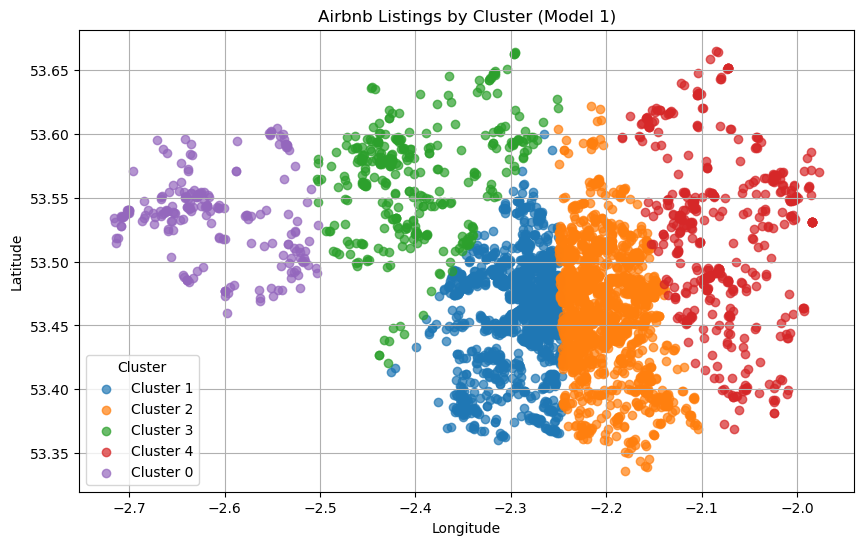

In [3]:
# Part 3:

# Your code goes here

import matplotlib.pyplot as plt
import pandas as pd

# load data
file_path = "D:/大学/AAAA_TCD的文件/AAAA_上课/CP4SS/final_project/cluster_airbnb_data.csv"
data = pd.read_csv(file_path)

# Model 1
# calculate median and mean prices by cluster
price_stats = data.groupby("cluster_lat_lon")["price"].agg(["mean", "median"]).reset_index()
print("Price Statistics by Cluster (Model 1):\n", price_stats)

# count room types by cluster
room_type_counts = data.groupby(["cluster_lat_lon", "room_type"]).size().unstack(fill_value=0)
print("\nRoom Type Counts by Cluster (Model 1):\n", room_type_counts)

# scatter plot of listing locations by cluster
plt.figure(figsize=(10, 6))
for cluster in data["cluster_lat_lon"].unique():
    cluster_data = data[data["cluster_lat_lon"] == cluster]
    plt.scatter(
        cluster_data["longitude"], 
        cluster_data["latitude"], 
        label=f"Cluster {cluster}", 
        alpha=0.7
    )
plt.title("Airbnb Listings by Cluster (Model 1)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


#### **Model 1 Coclusion**
The differences between mean and median prices suggest that pricing data is skewed, likely due to outliers in higher price ranges.
Geographic location impacts the type of accommodation available and the price range. Central clusters feature a mix of room types and higher prices, while outer clusters offer fewer options but are generally more affordable.

### **Model 2** - KMeans algorithm on latitude, longitude and price

Price Statistics by Cluster (Model 2):
    cluster_lat_lon_price          mean   median
0                      0    345.037736    293.0
1                      1   1395.028571   1000.0
2                      2  60000.000000  60000.0
3                      3  14819.500000  14819.5
4                      4     90.860979     85.0

Room Type Counts by Cluster (Model 2):
 room_type              Entire home/apt  Hotel room  Private room  Shared room
cluster_lat_lon_price                                                        
0                                  443           1            31            2
1                                   32           0             3            0
2                                    1           0             0            0
3                                    2           0             0            0
4                                 3593           0          2019           49


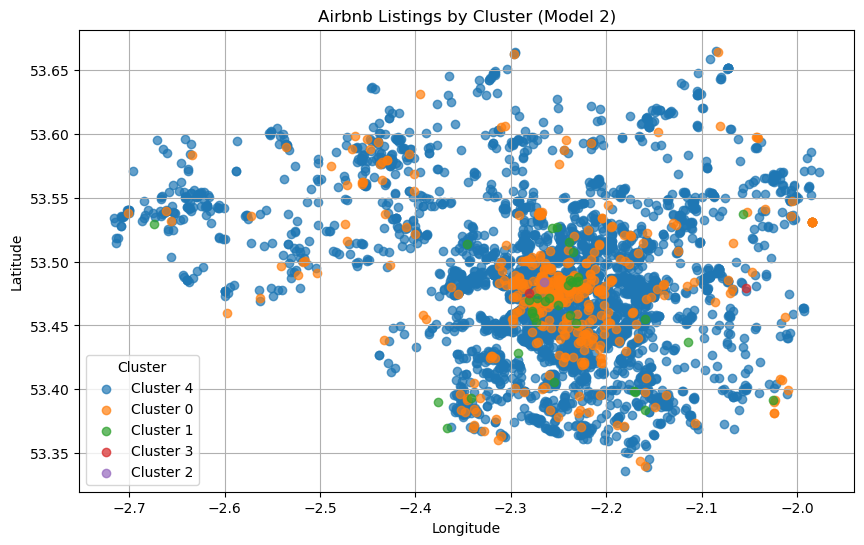

In [4]:
# Model 2
# calculate median and mean prices by cluster
price_stats = data.groupby("cluster_lat_lon_price")["price"].agg(["mean", "median"]).reset_index()
print("Price Statistics by Cluster (Model 2):\n", price_stats)

# count room types by cluster
room_type_counts = data.groupby(["cluster_lat_lon_price", "room_type"]).size().unstack(fill_value=0)
print("\nRoom Type Counts by Cluster (Model 2):\n", room_type_counts)

# scatter plot of listing locations by cluster
plt.figure(figsize=(10, 6))
for cluster in data["cluster_lat_lon_price"].unique():
    cluster_data = data[data["cluster_lat_lon_price"] == cluster]
    plt.scatter(
        cluster_data["longitude"], 
        cluster_data["latitude"], 
        label=f"Cluster {cluster}", 
        alpha=0.7
    )
plt.title("Airbnb Listings by Cluster (Model 2)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


#### **Model 2 Coclusion**
The inclusion of price as a clustering feature introduces significant segmentation based on listing costs:
- Clusters 0 and 4 represent more typical and accessible accommodations.
- Clusters 2 and 3 isolate luxury or high-priced properties, emphasizing their distinctiveness.
- The differences between mean and median highlight the impact of outliers, especially in luxury-oriented clusters.

This clustering method is particularly useful for identifying pricing extremes and market segmentation within Airbnb listings.

### **Model 3** - KMeans algorithm on latitude, longitude and room type

Price Statistics by Cluster (Model 3):
    cluster_lat_lon_room_type        mean  median
0                          0   52.221083    41.0
1                          1   51.077922    38.0
2                          2  169.779170   117.0
3                          3   64.467928    47.5
4                          4   82.980769    65.0

Room Type Counts by Cluster (Model 3):
 room_type                  Entire home/apt  Hotel room  Private room  \
cluster_lat_lon_room_type                                              
0                                        0           0           683   
1                                        0           0           154   
2                                     4071           0             0   
3                                        0           0          1216   
4                                        0           1             0   

room_type                  Shared room  
cluster_lat_lon_room_type               
0                                    0

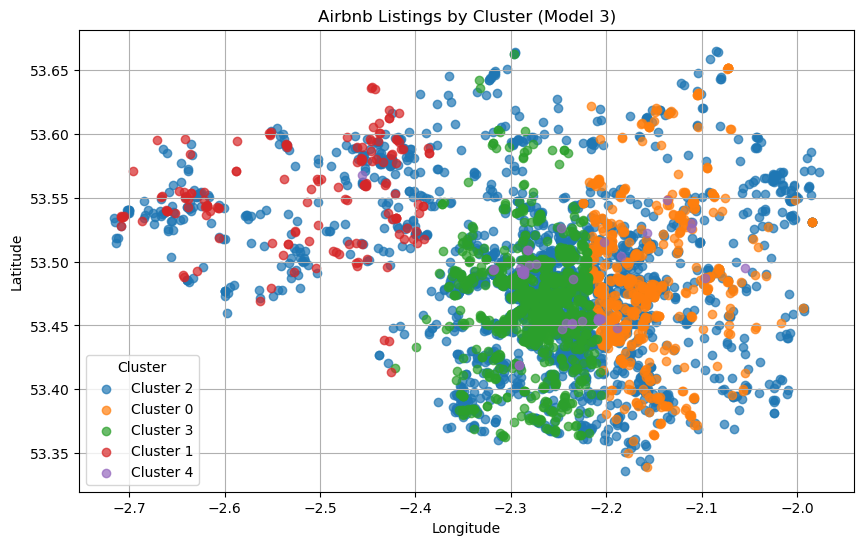

In [5]:
# model 3
# calculate median and mean prices by cluster
price_stats = data.groupby("cluster_lat_lon_room_type")["price"].agg(["mean", "median"]).reset_index()
print("Price Statistics by Cluster (Model 3):\n", price_stats)

# count room types by cluster
room_type_counts = data.groupby(["cluster_lat_lon_room_type", "room_type"]).size().unstack(fill_value=0)
print("\nRoom Type Counts by Cluster (Model 3):\n", room_type_counts)

# scatter plot of listing locations by cluster
plt.figure(figsize=(10, 6))
for cluster in data["cluster_lat_lon_room_type"].unique():
    cluster_data = data[data["cluster_lat_lon_room_type"] == cluster]
    plt.scatter(
        cluster_data["longitude"], 
        cluster_data["latitude"], 
        label=f"Cluster {cluster}", 
        alpha=0.7
    )
plt.title("Airbnb Listings by Cluster (Model 3)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

#### **Model 3 Coclusion**

- Price Differences: There is a noticeable difference between mean and median prices, with the mean often higher due to a few high-priced listings.
- Room Type Variation: The variation in room types across clusters suggests that different areas cater to different types of accommodation preferences or that there are differences in the supply of room types.
- Market Insights: The clustering results provide insights into the Airbnb market dynamics, such as the areas with higher activity and the types of accommodations that are more prevalent.
